In [319]:
""" ---------------- """
"""    The Basics    """
""" ---------------- """

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import time
import os
import csv
import json
import shutil
import re

from IPython.display import display, clear_output
import cv2
import pandas as pd
from scipy.signal import find_peaks

import pyautogui
import mne

from importlib import reload
import conditions

%matplotlib inline


""" ---------------------- """
"""    HELPER FUNCTIONS    """
""" ---------------------- """

def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item

# Src of Function: https://stackoverflow.com/questions/24005221/ipython-notebook-early-exit-from-cell
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

def InchToPixel(inches):
    return int(inches * 96)

# These three functions sort filenames "humanly" (as opposed to the default lexicographical sorting that computers understand)
# The user-friendly function to use is `sort_nicely(l)`, where `l` is a list of files where all contents are of type ____<#>.png
# Source: https://nedbatchelder.com/blog/200712/human_sorting.html
def tryint(s):
    try:
        return int(s)
    except:
        return s
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks. "z23a" -> ["z", 23, "a"] """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]
def sort_nicely(l):
    return sorted(l, key=alphanum_key) 

In [320]:
""" --------------------- """
"""    HYPERPARAMETERS    """
""" --------------------- """

_REFERENCE_CHANNELS = ["TP9","TP10"]   # Which channels should we re-reference the EEG data to?
_FREQUENCY_CHANNELS = ["AF7", "AF8"]   # Which channels are we interested in observing specifically?
_FREQUENCY_RANGE = (0.5, 80)           # What frequency will we bandpass filter for?
_POWER_RANGE = (0, 200)                # What is the power range of the Power Spectral Density graph that'll be produced? Purely visual in function
_PSD_AVG = "mean"                      # When calculating the Power Spectral Density, what metric should we aggregate data samples around?
_FIGSIZE = (10, 5)                     # When producing the PSD graph, what will the figure size be? Purely visual in function
_CHANNEL_COLORS = ["blue", "red"]      # When producing the PSD graph, what colors correspond to the channels in _FREQUENCY_CHANNELS? Purely visual in function
_SAVE_CSV = True                       # Should we save the raw EEG data as well as the processed data?
_VERBOSE = False                       # Should we be verbose and yell at the user about warnings, update messages, print statements, etc?

""" ========================================================================
THE FOLLOWING ARE NOT HYPERPARAMETERS AND MUST NOT BE ALTERED IN ANY WAY
======================================================================== """

frequency_bands = {
    "delta": {"range":(0.5,4),"color":"darkgray"},
    "theta": {"range":(4, 8),"color":"lightblue"},
    "alpha": {"range":(8, 16),"color":"blue"},
    "beta":  {"range":(16, 32),"color":"orange"},
    "gamma": {"range":(32, 80),"color":"red"}
}

#### Read EEG file

In [321]:
eeg = pd.read_csv('eeg.csv')
print(eeg.head())

   id       lsl_ts     unix_ts        TP9        AF7        AF8       TP10  \
0   0  668791.8927  1706554674  -5.859375 -46.875000 -61.523438 -23.925781   
1   0  668791.8927  1706554674  -5.859375 -46.875000 -61.523438 -23.925781   
2   1  668791.8945  1706554674 -10.742188 -49.316406 -59.570312 -21.484375   
3   1  668791.8945  1706554674 -10.742188 -49.316406 -59.570312 -21.484375   
4   2  668791.8962  1706554674 -18.066406 -49.316406 -54.687500 -24.414062   

          AUX  
0 -316.406250  
1 -316.406250  
2 -218.750000  
3 -218.750000  
4 -200.683594  


#### Read VR file and change column name

In [322]:
vr = pd.read_csv('vr.csv')
vr['unix_ms'] = vr['unix_ms'] / 1000
vr.rename(columns={'unix_ms':'unix_ts'}, inplace=True)
print(vr.head())

        unix_ts  event_type             title  description          x  \
0  1.706555e+09  Simulation  Simulation Start          NaN     0.0000   
1  1.706555e+09      Anchor              Left       Center   720.0000   
2  1.706555e+09      Anchor              Left     Top Left   434.0125   
3  1.706555e+09      Anchor              Left    Top Right  1005.9870   
4  1.706555e+09      Anchor              Left  Bottom Left   434.0125   

          y     z  
0    0.0000   0.0  
1  792.0000  10.0  
2  934.9938  10.0  
3  934.9938  10.0  
4  649.0062  10.0  


#### Info on EEG File

In [323]:
eeg = eeg.drop_duplicates()
eeg_start = eeg.iloc[0]['unix_ts']
eeg_end = eeg.iloc[-1]['unix_ts']
eeg_duration = eeg_end - eeg_start
eeg_size = len(eeg.index)
eeg_frequency = round(eeg_size / eeg_duration)
print('eeg_start: ' + str(eeg_start))
print('eeg_end: ' + str(eeg_end))
print('eeg_duration: ' + str(eeg_duration))

eeg_start: 1706554674.0
eeg_end: 1706555030.0
eeg_duration: 356.0


#### Info on VR File

In [324]:
vr_start = vr.iloc[0]['unix_ts']
vr_end = vr.iloc[-1]['unix_ts']
vr_duration = vr_end - vr_start
print('vr_start: ' + str(vr_start))
print('vr_end: ' + str(vr_end))
print('vr_duration: ' + str(vr_duration))

vr_start: 1706554630.136
vr_end: 1706554952.048
vr_duration: 321.91200017929077


#### Trim EEG file to match VR file

In [325]:
eeg = eeg[eeg['unix_ts'] <= vr_end]
eeg_end = eeg.iloc[-1]['unix_ts']
eeg_duration = eeg_end - eeg_start
eeg_size = len(eeg.index)
eeg_frequency = round(eeg_size / eeg_duration)
print('eeg_end: ' + str(eeg.iloc[-1]['unix_ts']))
print('eeg_duration: ' + str(eeg_duration))

eeg_end: 1706554952.0
eeg_duration: 278.0


#### Group VR data by timestamp

In [326]:
vr_grouped = vr.groupby(vr.columns[0])
vr_dict = {k: v for k, v in vr_grouped}

keys_to_remove = [key for key in vr_dict if key < eeg_start]
for key in keys_to_remove:
    del vr_dict[key]
counter = 0

for key, df in vr_dict.items():
    print(type(key))
    print(f"Key: {key}")
    print(df.head())
    print("\n")

    counter += 1

    if counter >= 10:
        break

<class 'float'>
Key: 1706554674.011
            unix_ts    event_type        title description          x  \
20324  1.706555e+09        Player     position         NaN   3.281348   
20325  1.706555e+09        Player  orientation         NaN  15.370340   
20326  1.706555e+09  Eye Tracking         Left   Direction   0.177770   
20327  1.706555e+09  Eye Tracking        Right   Direction   0.126327   
20328  1.706555e+09  Eye Tracking       Center   Direction   0.127403   

                y          z  
20324    1.514836  18.334330  
20325  288.112900   2.263835  
20326   -0.300540   0.937056  
20327   -0.303569   0.944398  
20328   -0.283479   0.950478  


<class 'float'>
Key: 1706554674.025
            unix_ts    event_type        title description          x  \
20331  1.706555e+09        Player     position         NaN   3.262299   
20332  1.706555e+09        Player  orientation         NaN  15.532260   
20333  1.706555e+09  Eye Tracking         Left   Direction   0.170198   
20334  1.

#### YOLO Object Detection csv

In [327]:
video_start = 1706554451.504

eeg = eeg[eeg['unix_ts'] >= video_start]
vr = vr[vr['unix_ts'] >= video_start]
print('eeg no. of rows: ' + str(len(eeg.index)))
print('vr no. of rows: ' + str(len(vr.index)))

eeg no. of rows: 142295
vr no. of rows: 159592


In [328]:
print('EEG starts ' + str(eeg.iloc[0]['unix_ts'] - video_start) + 's after video start')

EEG starts 222.4960000514984s after video start


In [329]:
print('VR starts ' + str(vr.iloc[0]['unix_ts'] - video_start) + 's after video start')

VR starts 178.63199996948242s after video start


#### Reading YOLO Object Detection csv

In [330]:
predicted_labels = pd.read_csv('YOLOv8 [3 epochs]/predicted_labels_YOLO_3_epochs.csv')
predicted_labels['timestamp'] += video_start
print(predicted_labels.head())

      timestamp  class_name  class_id  confidence  \
0  1.706554e+09       mouse        64          73   
1  1.706554e+09  cell phone        67          34   
2  1.706554e+09  cell phone        67          53   
3  1.706554e+09  cell phone        67          46   
4  1.706554e+09  cell phone        67          49   

                                           box_coord  
0  [279.4248352050781, 602.07470703125, 538.87469...  
1  [373.49749755859375, 421.05535888671875, 308.3...  
2  [375.1658935546875, 417.2944641113281, 307.773...  
3  [375.03997802734375, 416.125, 306.884002685546...  
4  [377.3701171875, 414.65960693359375, 306.41040...  


#### Eye Cursor csv

In [331]:
eye_cursor = pd.read_csv('Eye Cursor/camera_with_cursor.csv')
eye_cursor['unix_ts'] += video_start
print(eye_cursor.head())

        unix_ts  frame    x    y
0  1.706554e+09  15544  356  303
1  1.706554e+09  15545  358  301
2  1.706554e+09  15546  358  301
3  1.706554e+09  15547  359  301
4  1.706554e+09  15548  357  304


#### Preparing EEG data for PSD

In [332]:
eeg = eeg.drop_duplicates()
eeg_info = mne.create_info(["TP9","TP10","AF7", "AF8"], eeg_frequency, ch_types='eeg', verbose=False)
s_array = np.transpose(eeg[["TP9", "TP10", "AF7", "AF8"]].to_numpy())
mne_info = mne.io.RawArray(s_array, eeg_info, first_samp=0, copy='auto', verbose=False)
mne_info.filter(0, 100, verbose=False)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


#### Plot PSD

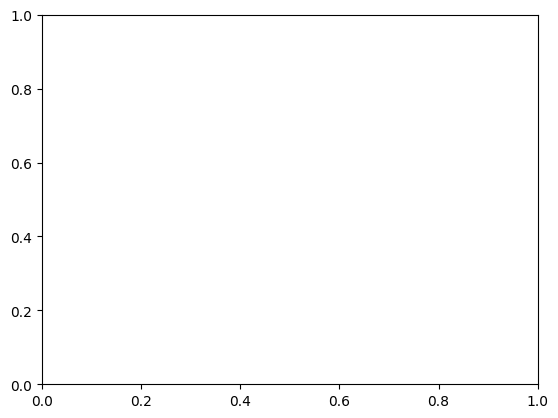

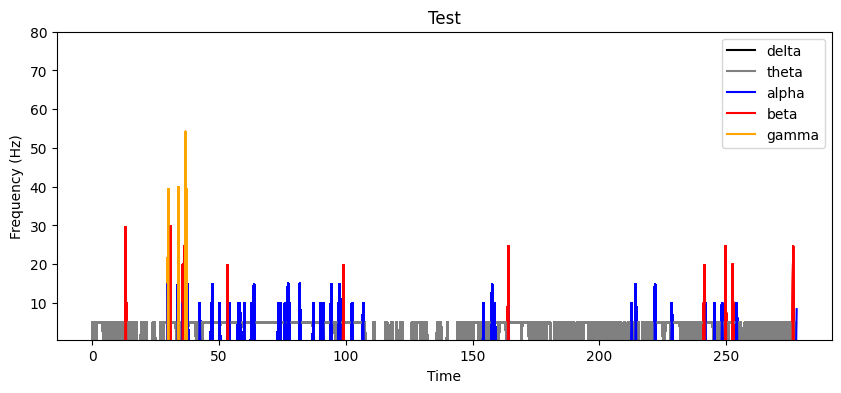

In [333]:
frequencies=["delta","theta","alpha","beta","gamma"]
colors=["black","gray","blue","red","orange"]
added_labels = []
handles, labels = plt.gca().get_legend_handles_labels()
fig, ax = plt.subplots(1,1,figsize=(10,4))
t = "Test"
plt.title(t)
plt.ylim(bottom=0.5)
plt.ylim(top=80)

ax.set_xlabel("Time")
ax.set_ylabel("Frequency (Hz)")

x = []
y = {}
z = {}
for freq in frequencies:
    y[freq] = []
    z[freq] = []

start = 0
end = eeg_duration
time_space = np.linspace(start, end, np.int64(eeg_duration) * 5)
for i in range(len(time_space) - 1):
    x.append(time_space[i])
    tmax = time_space[i + 1]
    tmin = time_space[i]
    if tmax > end:
        break
    psd = mne_info.compute_psd(tmin=tmin, tmax=tmax, average='mean', verbose=False)
    powers, freqs = psd.get_data(picks=["AF7", "AF8"], return_freqs=True)
    peak_freqs = {}
    peak_powers = {}
    for freq in frequencies:
        peak_freqs[freq] = []
        peak_powers[freq] = []
    if len(powers) > 0:
        for i in range(len(["AF7", "AF8"])):
            peaks, _ = find_peaks(powers[i], threshold=50)
            for peak in peaks:
                peak_freq = freqs[peak]
                peak_power = powers[i][peak]
                for freq in frequencies:
                    if peak_freq >= frequency_bands[freq]["range"][0] and peak_freq < frequency_bands[freq]["range"][1]:
                        peak_freqs[freq].append(peak_freq)
                        peak_powers[freq].append(peak_power)
        for freq in frequencies:
            if len(peak_powers[freq]) > 0:
                dict = {}
                dict['rel_tmax'] = tmax
                dict['rel_tmin'] = tmin
                dict['abs_tmax'] = tmax + eeg_start
                dict['abs_tmin'] = tmin + eeg_start
                dict['freq_value'] = np.mean(peak_freqs[freq])
                y[freq].append(np.mean(peak_freqs[freq]))
                z[freq].append(dict)
            else:
                dict = {}
                dict['rel_tmax'] = tmax
                dict['rel_tmin'] = tmin
                dict['abs_tmax'] = tmax + eeg_start
                dict['abs_tmin'] = tmin + eeg_start
                dict['freq_value'] = 0
                y[freq].append(0)
                z[freq].append(dict)

        for i in range(len(frequencies)):
            freq = frequencies[i]
            col = colors[i]
            plt.plot(x, y[freq], label=freq, color=col)
            if freq in added_labels: continue
            event_line = Line2D([0], [0], label=freq, color=col)
            handles.extend([event_line])
            added_labels.append(freq)

plt.legend(handles=handles)
plt.show()

#### Gamma Spikes

In [334]:
gamma_spikes = []
for dict in z['gamma']:
    if (dict['freq_value'] != 0):
        print(dict)
        gamma_spikes.append(dict)

{'rel_tmax': 30.22174226061915, 'rel_tmin': 30.021598272138228, 'abs_tmax': 1706554704.2217422, 'abs_tmin': 1706554704.0215983, 'freq_value': 39.38461538461539}
{'rel_tmax': 34.22462203023758, 'rel_tmin': 34.02447804175666, 'abs_tmax': 1706554708.224622, 'abs_tmin': 1706554708.024478, 'freq_value': 39.76699029126213}
{'rel_tmax': 37.02663786897048, 'rel_tmin': 36.82649388048956, 'abs_tmax': 1706554711.0266378, 'abs_tmin': 1706554710.826494, 'freq_value': 54.15384615384616}
{'rel_tmax': 37.426925845932324, 'rel_tmin': 37.2267818574514, 'abs_tmax': 1706554711.426926, 'abs_tmin': 1706554711.2267818, 'freq_value': 39.38461538461539}


#### Processing VR data for Gamma

In [335]:
for items in gamma_spikes:
    print(items)

gamma_spikes_vr = []

for items in gamma_spikes:
    start = items['abs_tmin']
    end = items['abs_tmax']
    dict = {}
    dict['abs_tmax'] = items['abs_tmax']
    dict['abs_tmin'] = items['abs_tmin']
    dict['freq_value'] = items['freq_value']
    dict['vr'] = []
    for key, df in vr_dict.items():
        if np.float64(key) >= start and np.float64(key) < end:
            dict2 = {}
            dict2['unix_ts'] = key
            dict2['coordinates'] = df
            dict['vr'].append(dict2)
    
    dict['objects'] = []
    for key, df in predicted_labels.iterrows():
        if df['timestamp'] >= start and df['timestamp'] < end:
            dict3 = {}
            dict3['unix_ts'] = df['timestamp']
            dict3['class_name'] = df['class_name']
            dict3['coordinates'] = df['box_coord']
            dict3['confidence'] = df['confidence']
            dict['objects'].append(dict3)

    gamma_spikes_vr.append(dict)

for i in range(len(gamma_spikes_vr)):
    gamma_spikes_vr[i]['vr'] = sorted(gamma_spikes_vr[i]['vr'], key=lambda x: x['unix_ts'])
    gamma_spikes_vr[i]['objects'] = sorted(gamma_spikes_vr[i]['objects'], key=lambda x: x['unix_ts'])


{'rel_tmax': 30.22174226061915, 'rel_tmin': 30.021598272138228, 'abs_tmax': 1706554704.2217422, 'abs_tmin': 1706554704.0215983, 'freq_value': 39.38461538461539}
{'rel_tmax': 34.22462203023758, 'rel_tmin': 34.02447804175666, 'abs_tmax': 1706554708.224622, 'abs_tmin': 1706554708.024478, 'freq_value': 39.76699029126213}
{'rel_tmax': 37.02663786897048, 'rel_tmin': 36.82649388048956, 'abs_tmax': 1706554711.0266378, 'abs_tmin': 1706554710.826494, 'freq_value': 54.15384615384616}
{'rel_tmax': 37.426925845932324, 'rel_tmin': 37.2267818574514, 'abs_tmax': 1706554711.426926, 'abs_tmin': 1706554711.2267818, 'freq_value': 39.38461538461539}


#### An element of gamma_spikes_vr array:
{

'abs_tmin': float
'abs_tmin': float
'freq_value': float
'vr': [ {'unix_ts': float, 'coordinates': df} ,  ....]
'objects': [ {'unix_ts': float, 'class_name': string, 'confidence': int, 'coordinates': string} , ....]

}


In [336]:
for element in gamma_spikes_vr:
    print(element['abs_tmin'])
    print(element['abs_tmax'])
    print('\n')
    for object in element['objects']:
        timestamp = object['unix_ts']
        coordinates = json.loads(object['coordinates'])
        x_lower = coordinates[0] - ((coordinates[2] / 2) / 2)
        x_upper = coordinates[0] + ((coordinates[2] / 2) / 2)
        y_lower = coordinates[1] - ((coordinates[3] / 2) / 2)
        y_upper = coordinates[1] + ((coordinates[3] / 2) / 2)
        
        for index , df in eye_cursor.iterrows():
            if df['unix_ts'] < timestamp + 0.01 and df['unix_ts'] >= timestamp - 0.01:
                if df['x'] <= x_upper and df['x'] >= x_lower and df['y'] <= y_upper and df['y'] >= y_lower:
                    print('class_name: ' + object['class_name'] + ', coordinates: ' + str(coordinates))
                    break
    print('\n\n')

1706554704.0215983
1706554704.2217422





1706554708.024478
1706554708.224622




1706554710.826494
1706554711.0266378

class_name: person, coordinates: [302.0079650878906, 353.5409851074219, 146.58763122558594, 362.02862548828125]
class_name: person, coordinates: [302.8441467285156, 349.93695068359375, 142.9616241455078, 361.38134765625]
class_name: person, coordinates: [285.6649169921875, 354.11627197265625, 164.37025451660156, 375.98779296875]
class_name: person, coordinates: [284.8166809082031, 355.3686218261719, 163.64036560058594, 378.20111083984375]
class_name: person, coordinates: [273.53759765625, 361.5863342285156, 177.09292602539062, 387.67803955078125]
class_name: person, coordinates: [272.4756774902344, 365.86236572265625, 180.9317169189453, 390.050537109375]
class_name: person, coordinates: [267.4013671875, 371.2870178222656, 186.8339385986328, 397.53265380859375]
class_name: person, coordinates: [264.4113464355469, 374.0245666503906, 190.38458251953125, 402.755065917968

#### Processing VR data for Beta

In [337]:
beta_spikes = []
for dict in z['beta']:
    if (dict['freq_value'] != 0):
        print(dict)
        beta_spikes.append(dict)

{'rel_tmax': 13.409647228221742, 'rel_tmin': 13.20950323974082, 'abs_tmax': 1706554687.4096472, 'abs_tmin': 1706554687.2095032, 'freq_value': 29.53846153846154}
{'rel_tmax': 31.022318214542835, 'rel_tmin': 30.822174226061914, 'abs_tmax': 1706554705.0223181, 'abs_tmin': 1706554704.8221743, 'freq_value': 29.8252427184466}
{'rel_tmax': 36.025917926565874, 'rel_tmin': 35.82577393808495, 'abs_tmax': 1706554710.025918, 'abs_tmin': 1706554709.825774, 'freq_value': 19.883495145631066}
{'rel_tmax': 36.62634989200864, 'rel_tmin': 36.426205903527716, 'abs_tmax': 1706554710.62635, 'abs_tmin': 1706554710.4262059, 'freq_value': 24.615384615384617}
{'rel_tmax': 37.02663786897048, 'rel_tmin': 36.82649388048956, 'abs_tmax': 1706554711.0266378, 'abs_tmin': 1706554710.826494, 'freq_value': 29.53846153846154}
{'rel_tmax': 53.638588912886966, 'rel_tmin': 53.43844492440605, 'abs_tmax': 1706554727.638589, 'abs_tmin': 1706554727.4384449, 'freq_value': 19.692307692307693}
{'rel_tmax': 99.27141828653707, 'rel_t

In [338]:
for items in beta_spikes:
    print(items)

beta_spikes_vr = []

for items in beta_spikes:
    start = items['abs_tmin']
    end = items['abs_tmax']
    dict = {}
    dict['abs_tmax'] = items['abs_tmax']
    dict['abs_tmin'] = items['abs_tmin']
    dict['freq_value'] = items['freq_value']
    dict['vr'] = []
    for key, df in vr_dict.items():
        if np.float64(key) >= start and np.float64(key) < end:
            dict2 = {}
            dict2['unix_ts'] = key
            dict2['coordinates'] = df
            dict['vr'].append(dict2)

    dict['objects'] = []
    for key, df in predicted_labels.iterrows():
        if df['timestamp'] >= start and df['timestamp'] < end:
            dict3 = {}
            dict3['unix_ts'] = df['timestamp']
            dict3['class_name'] = df['class_name']
            dict3['coordinates'] = df['box_coord']
            dict3['confidence'] = df['confidence']
            dict['objects'].append(dict3)

    beta_spikes_vr.append(dict)

for i in range(len(beta_spikes_vr)):
    beta_spikes_vr[i]['vr'] = sorted(beta_spikes_vr[i]['vr'], key=lambda x: x['unix_ts'])
    beta_spikes_vr[i]['objects'] = sorted(beta_spikes_vr[i]['objects'], key=lambda x: x['unix_ts'])


{'rel_tmax': 13.409647228221742, 'rel_tmin': 13.20950323974082, 'abs_tmax': 1706554687.4096472, 'abs_tmin': 1706554687.2095032, 'freq_value': 29.53846153846154}
{'rel_tmax': 31.022318214542835, 'rel_tmin': 30.822174226061914, 'abs_tmax': 1706554705.0223181, 'abs_tmin': 1706554704.8221743, 'freq_value': 29.8252427184466}
{'rel_tmax': 36.025917926565874, 'rel_tmin': 35.82577393808495, 'abs_tmax': 1706554710.025918, 'abs_tmin': 1706554709.825774, 'freq_value': 19.883495145631066}
{'rel_tmax': 36.62634989200864, 'rel_tmin': 36.426205903527716, 'abs_tmax': 1706554710.62635, 'abs_tmin': 1706554710.4262059, 'freq_value': 24.615384615384617}
{'rel_tmax': 37.02663786897048, 'rel_tmin': 36.82649388048956, 'abs_tmax': 1706554711.0266378, 'abs_tmin': 1706554710.826494, 'freq_value': 29.53846153846154}
{'rel_tmax': 53.638588912886966, 'rel_tmin': 53.43844492440605, 'abs_tmax': 1706554727.638589, 'abs_tmin': 1706554727.4384449, 'freq_value': 19.692307692307693}
{'rel_tmax': 99.27141828653707, 'rel_t

In [339]:
for element in beta_spikes_vr:
    print(element['abs_tmin'])
    print(element['abs_tmax'])
    print('\n')
    for object in element['objects']:
        timestamp = object['unix_ts']
        coordinates = json.loads(object['coordinates'])
        x_lower = coordinates[0] - ((coordinates[2] / 2) / 2)
        x_upper = coordinates[0] + ((coordinates[2] / 2) / 2)
        y_lower = coordinates[1] - ((coordinates[3] / 2) / 2)
        y_upper = coordinates[1] + ((coordinates[3] / 2) / 2)

        for index , df in eye_cursor.iterrows():
            if df['unix_ts'] < timestamp + 0.01 and df['unix_ts'] >= timestamp - 0.01:
                if df['x'] <= x_upper and df['x'] >= x_lower and df['y'] <= y_upper and df['y'] >= y_lower:
                    print('class_name: ' + object['class_name'] + ', coordinates: ' + str(coordinates))
                    break
    print('\n\n')

1706554687.2095032
1706554687.4096472




1706554704.8221743
1706554705.0223181





1706554709.825774
1706554710.025918

class_name: person, coordinates: [259.5360107421875, 387.1524353027344, 176.293701171875, 569.5811157226562]
class_name: person, coordinates: [270.8228454589844, 389.0627746582031, 176.1183319091797, 563.8643188476562]



1706554710.4262059
1706554710.62635

class_name: person, coordinates: [248.65713500976562, 294.86517333984375, 107.80464172363281, 261.6365966796875]
class_name: person, coordinates: [229.68392944335938, 295.8879089355469, 111.62986755371094, 262.98980712890625]
class_name: bicycle, coordinates: [264.1559143066406, 297.7107238769531, 61.45408630371094, 96.31007385253906]
class_name: bicycle, coordinates: [241.3876495361328, 303.40704345703125, 63.117095947265625, 94.69711303710938]



1706554710.826494
1706554711.0266378

class_name: person, coordinates: [302.0079650878906, 353.5409851074219, 146.58763122558594, 362.02862548828125]
class_name: pers

#### Processing VR data for Beta

In [340]:
alpha_dips = []
for i in range(len(z['alpha']) - 130):
    if (z['alpha'][i]['freq_value'] == 0):
        count = 0
        for j in range(130):
            if (z['alpha'][i+j+1]['freq_value']) == 0:
                count += 1
        if count == 130:
            print(z['alpha'][i])
            alpha_dips.append(z['alpha'][i])

print(len(alpha_dips))

{'rel_tmax': 0.20014398848092152, 'rel_tmin': 0.0, 'abs_tmax': 1706554674.200144, 'abs_tmin': 1706554674.0, 'freq_value': 0}
{'rel_tmax': 0.40028797696184304, 'rel_tmin': 0.20014398848092152, 'abs_tmax': 1706554674.4002879, 'abs_tmin': 1706554674.200144, 'freq_value': 0}
{'rel_tmax': 0.6004319654427646, 'rel_tmin': 0.40028797696184304, 'abs_tmax': 1706554674.600432, 'abs_tmin': 1706554674.4002879, 'freq_value': 0}
{'rel_tmax': 0.8005759539236861, 'rel_tmin': 0.6004319654427646, 'abs_tmax': 1706554674.800576, 'abs_tmin': 1706554674.600432, 'freq_value': 0}
{'rel_tmax': 1.0007199424046076, 'rel_tmin': 0.8005759539236861, 'abs_tmax': 1706554675.00072, 'abs_tmin': 1706554674.800576, 'freq_value': 0}
{'rel_tmax': 1.2008639308855291, 'rel_tmin': 1.0007199424046076, 'abs_tmax': 1706554675.2008638, 'abs_tmin': 1706554675.00072, 'freq_value': 0}
{'rel_tmax': 1.4010079193664506, 'rel_tmin': 1.2008639308855291, 'abs_tmax': 1706554675.401008, 'abs_tmin': 1706554675.2008638, 'freq_value': 0}
{'rel_

In [341]:
for items in alpha_dips:
    print(items)

alpha_dips_vr = []

for items in alpha_dips:
    start = items['abs_tmin']
    end = items['abs_tmax']
    dict = {}
    dict['abs_tmax'] = items['abs_tmax']
    dict['abs_tmin'] = items['abs_tmin']
    dict['freq_value'] = items['freq_value']
    dict['vr'] = []
    for key, df in vr_dict.items():
        if np.float64(key) >= start and np.float64(key) < end:
            dict2 = {}
            dict2['unix_ts'] = key
            dict2['coordinates'] = df
            dict['vr'].append(dict2)

    dict['objects'] = []
    for key, df in predicted_labels.iterrows():
        if df['timestamp'] >= start and df['timestamp'] < end:
            dict3 = {}
            dict3['unix_ts'] = df['timestamp']
            dict3['class_name'] = df['class_name']
            dict3['coordinates'] = df['box_coord']
            dict3['confidence'] = df['confidence']
            dict['objects'].append(dict3)

    alpha_dips_vr.append(dict)

for i in range(len(alpha_dips_vr)):
    alpha_dips_vr[i]['vr'] = sorted(alpha_dips_vr[i]['vr'], key=lambda x: x['unix_ts'])
    alpha_dips_vr[i]['objects'] = sorted(alpha_dips_vr[i]['objects'], key=lambda x: x['unix_ts'])


{'rel_tmax': 0.20014398848092152, 'rel_tmin': 0.0, 'abs_tmax': 1706554674.200144, 'abs_tmin': 1706554674.0, 'freq_value': 0}
{'rel_tmax': 0.40028797696184304, 'rel_tmin': 0.20014398848092152, 'abs_tmax': 1706554674.4002879, 'abs_tmin': 1706554674.200144, 'freq_value': 0}
{'rel_tmax': 0.6004319654427646, 'rel_tmin': 0.40028797696184304, 'abs_tmax': 1706554674.600432, 'abs_tmin': 1706554674.4002879, 'freq_value': 0}
{'rel_tmax': 0.8005759539236861, 'rel_tmin': 0.6004319654427646, 'abs_tmax': 1706554674.800576, 'abs_tmin': 1706554674.600432, 'freq_value': 0}
{'rel_tmax': 1.0007199424046076, 'rel_tmin': 0.8005759539236861, 'abs_tmax': 1706554675.00072, 'abs_tmin': 1706554674.800576, 'freq_value': 0}
{'rel_tmax': 1.2008639308855291, 'rel_tmin': 1.0007199424046076, 'abs_tmax': 1706554675.2008638, 'abs_tmin': 1706554675.00072, 'freq_value': 0}
{'rel_tmax': 1.4010079193664506, 'rel_tmin': 1.2008639308855291, 'abs_tmax': 1706554675.401008, 'abs_tmin': 1706554675.2008638, 'freq_value': 0}
{'rel_

In [ ]:
for element in alpha_dips_vr:
    print(element['abs_tmin'])
    print(element['abs_tmax'])
    print('\n')
    for object in element['objects']:
        timestamp = object['unix_ts']
        coordinates = json.loads(object['coordinates'])
        x_lower = coordinates[0] - ((coordinates[2] / 2) / 2)
        x_upper = coordinates[0] + ((coordinates[2] / 2) / 2)
        y_lower = coordinates[1] - ((coordinates[3] / 2) / 2)
        y_upper = coordinates[1] + ((coordinates[3] / 2) / 2)

        for index , df in eye_cursor.iterrows():
            if df['unix_ts'] < timestamp + 0.01 and df['unix_ts'] >= timestamp - 0.01:
                if df['x'] <= x_upper and df['x'] >= x_lower and df['y'] <= y_upper and df['y'] >= y_lower:
                    print('class_name: ' + object['class_name'] + ', coordinates: ' + str(coordinates))
                    break
    print('\n\n')

1706554674.0
1706554674.200144




1706554674.200144
1706554674.4002879




1706554674.4002879
1706554674.600432




1706554674.600432
1706554674.800576




1706554674.800576
1706554675.00072




1706554675.00072
1706554675.2008638




1706554675.2008638
1706554675.401008




1706554675.401008
1706554675.601152




1706554675.601152
1706554675.801296




1706554675.801296
1706554676.0014398




1706554676.0014398
1706554676.2015839




1706554676.2015839
1706554676.401728

class_name: person, coordinates: [589.921142578125, 354.81781005859375, 62.62396240234375, 126.56179809570312]
class_name: person, coordinates: [589.7261962890625, 352.3658447265625, 56.99261474609375, 125.52352905273438]
class_name: person, coordinates: [586.2780151367188, 352.75750732421875, 64.204345703125, 131.95364379882812]
class_name: person, coordinates: [587.3228759765625, 337.94439697265625, 59.31976318359375, 116.43228149414062]



1706554676.401728
1706554676.601872




1706554676.601872
1706554676.802015